In [ ]:
!pip install monai

In [3]:
!pip install torchinfo

In [4]:
# import libraries
import os
import torch
import torch.nn as nn
import monai
import numpy as np
import torchvision
import matplotlib
import matplotlib.pyplot as plt
###
from monai.data import Dataset as TorchDataset
from monai.data import DataLoader
from monai.transforms import Compose, ToTensor
from monai.networks.nets import AutoencoderKL
###
from torch.utils.data import random_split
from torchvision import datasets, transforms
from torchinfo import summary
###
from matplotlib.animation import FuncAnimation
from sklearn.manifold import TSNE
from IPython.display import Image, display
%matplotlib inline

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Monai version: {monai.__version__}")


PyTorch version: 2.8.0+cu126
Torchvision version: 0.23.0+cu126
Numpy version: 2.0.2
Monai version: 1.5.1


In [5]:
# Define a method to Scale the intensity of the input data between minv and maxv
class ScaleIntensity:
    def __init__(self, minv=0.0, maxv=1.0):
        self.minv = minv
        self.maxv = maxv

    def __call__(self, img):
        img_min, img_max = img.min(), img.max()
        img = (img - img_min) / (img_max - img_min)  # Normaliser entre 0 et 1
        img = img * (self.maxv - self.minv) + self.minv  # Rescaler entre minv et maxv
        return img

In [6]:
# how many samples per batch to load
batch_size = 64

# define intensity range for each input data to perform image normalization
minv = 0
maxv = 1

# convert data to torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad(padding=2),
    ScaleIntensity(minv=minv, maxv=maxv)
])

# Path to store MNIST dataset
data_dir = "data/MNIST"

# Checks if data has already been downloaded
download = not os.path.exists(data_dir)

# Choose the training and test datasets
train_dataset = datasets.MNIST(root='data', train=True, download=download, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=download, transform=transform)

# Split the train_data into a train (80%) and valid (20%) subdataset
train_size = int(0.8 * len(train_dataset))      # 80% for training
valid_size = len(train_dataset) - train_size    # 20% for validation
train_data, valid_data = random_split(train_dataset, [train_size, valid_size])

# Convert data to MONAI Dataset
train_dataset = TorchDataset(data=[{"image": img, "label": label} for img, label in train_data], transform=None)
valid_dataset = TorchDataset(data=[{"image": img, "label": label} for img, label in valid_data], transform=None)
test_dataset = TorchDataset(data=[{"image": img, "label": label} for img, label in test_data], transform=None)

#  Create DataLoaders to train and validate the model
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

print(f"Training dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(valid_loader.dataset)}")
print(f"Test dataset size: {len(test_loader.dataset)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.6MB/s]


Training dataset size: 48000
Validation dataset size: 12000
Test dataset size: 12000


The image batch size is (64, 1, 32, 32)


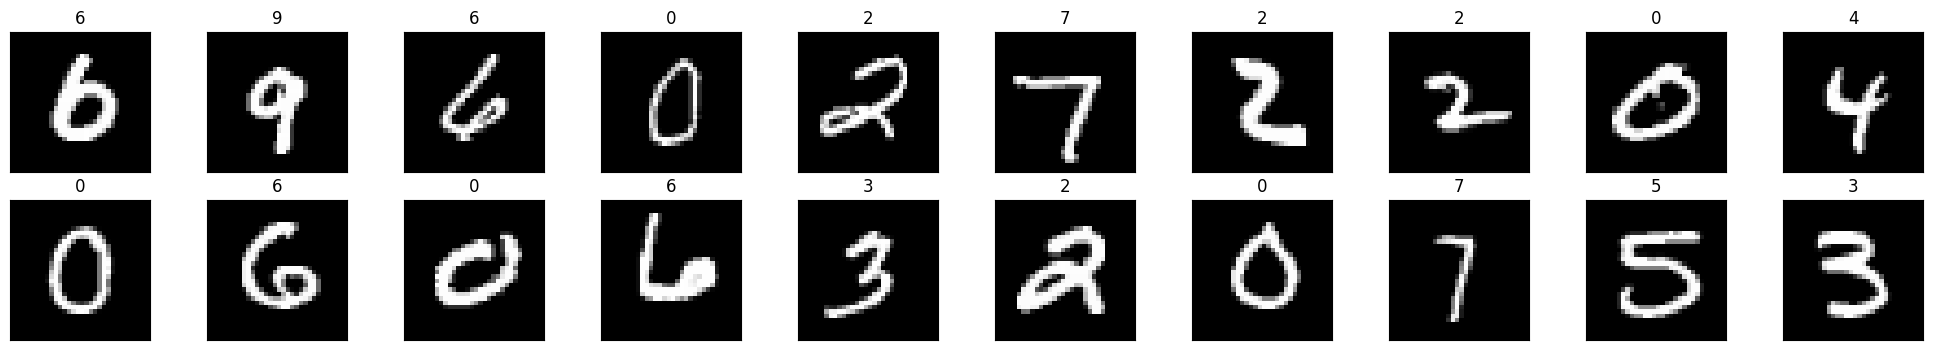

In [7]:
# obtain one batch of training images
dataiter_train = iter(train_loader)
batch = next(dataiter_train)
images, labels = batch["image"], batch["label"]
images = images.numpy()
print(f"The image batch size is {images.shape}")

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

The size of an image from the dataset is (32, 32)


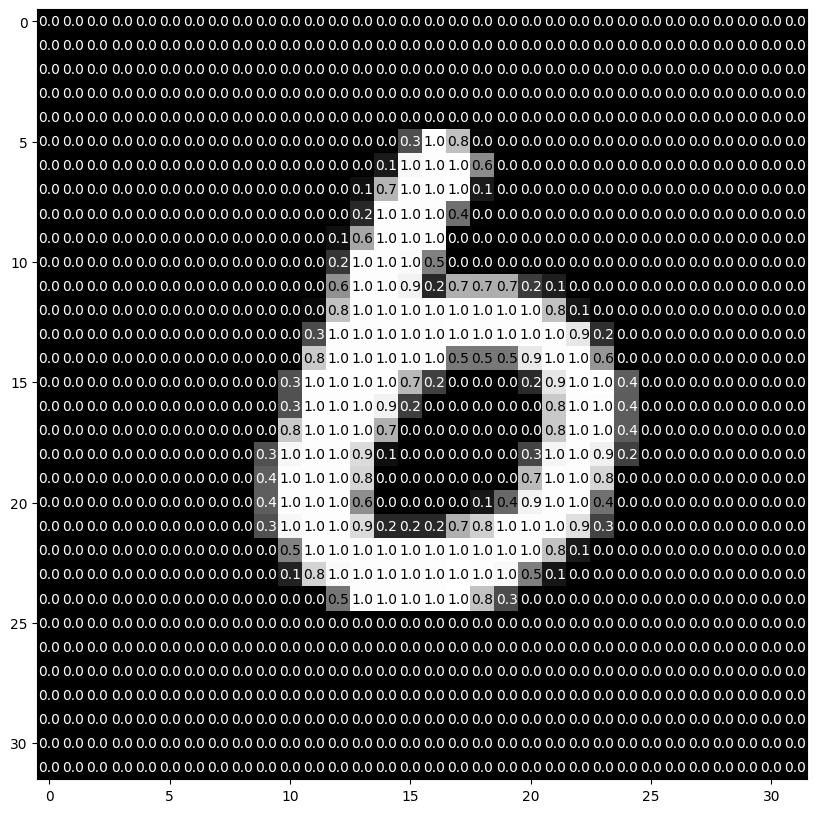

In [8]:
img = np.squeeze(images[0])
print(f"The size of an image from the dataset is {img.shape}")

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(f"{val:.1f}", xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [9]:
# Parameters
spatial_dims = 2
in_shape = (1, 32, 32)
in_channels = 1
out_channels = 1
latent_size = 2
channels = (16, 32, 64)
latent_channels = 4
num_res_blocks = 1
norm_num_groups = channels[0]
attention_levels = (False, False, False)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoencoderKL(
    spatial_dims=spatial_dims,
    in_channels=in_channels,
    out_channels=out_channels,
    channels=channels,
    latent_channels=latent_channels,
    num_res_blocks=num_res_blocks,
    norm_num_groups=norm_num_groups,
    attention_levels=attention_levels,
)
model.to(device)

AutoencoderKL(
  (encoder): Encoder(
    (blocks): ModuleList(
      (0): Convolution(
        (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): AEKLResBlock(
        (norm1): GroupNorm(16, 16, eps=1e-06, affine=True)
        (conv1): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (norm2): GroupNorm(16, 16, eps=1e-06, affine=True)
        (conv2): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (nin_shortcut): Identity()
      )
      (2): AEKLDownsample(
        (pad): AsymmetricPad()
        (conv): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (3): AEKLResBlock(
        (norm1): GroupNorm(16, 16, eps=1e-06, affine=True)
        (conv1): Convolution(
          (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (

In [ ]:
# Print the summary of the encoder network
summary_kwargs = dict(
    col_names=["input_size", "output_size", "num_params"], depth=3, verbose=0
)
summary(model, (1, 1, 32, 32), device="cpu", **summary_kwargs)

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #
AutoencoderKL                                 [1, 1, 32, 32]            [1, 1, 32, 32]            --
├─Encoder: 1-1                                [1, 1, 32, 32]            [1, 4, 8, 8]              --
│    └─ModuleList: 2-1                        --                        --                        --
│    │    └─Convolution: 3-1                  [1, 1, 32, 32]            [1, 16, 32, 32]           160
│    │    └─AEKLResBlock: 3-2                 [1, 16, 32, 32]           [1, 16, 32, 32]           4,704
│    │    └─AEKLDownsample: 3-3               [1, 16, 32, 32]           [1, 16, 16, 16]           2,320
│    │    └─AEKLResBlock: 3-4                 [1, 16, 16, 16]           [1, 32, 16, 16]           14,528
│    │    └─AEKLDownsample: 3-5               [1, 32, 16, 16]           [1, 32, 8, 8]             9,248
│    │    └─AEKLResBlock: 3-6                 [1, 32, 8, 8]             

In [12]:
## Specify loss and optimization functions
learning_rate = 0.0001
l1_loss = nn.L1Loss()

def vae_gaussian_kl_loss_log(mu, logvar):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return KLD.mean()

def vae_gaussian_kl_loss(mu, sigma):
    kl_loss = 0.5 * torch.sum(mu.pow(2) + sigma.pow(2) - torch.log(sigma.pow(2)) - 1, dim=[1, 2, 3])
    kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]
    return kl_loss

def reconstruction_loss(x_reconstructed, x):
    # bce_loss = nn.BCELoss()
    l1_loss = nn.L1Loss()
    return l1_loss(x_reconstructed, x)

def loss_function(recon_x, x, mu, sigma, kl_weight):
    recon_loss = reconstruction_loss(recon_x, x)
    kld_loss = vae_gaussian_kl_loss(mu, sigma)
    return recon_loss + kl_weight * kld_loss, recon_loss.item(), kl_weight * kld_loss.item()

# Specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
# Number of epochs to train the model
n_epochs = 20
kl_weight = 1e-4    # Value to be tested: 1e-4, 1e-3, 1e-2, 1e-1

# Move the model to the device
model = model.to(device)

# Lists to store loss and accuracy for each epoch
train_loss_list = []
valid_metric_list = []
recon_metric_list = []
kld_metric_list = []

best_valid_metric = float('inf')  # to track the best validation mesasure
best_model = None  # to store the best model
best_epoch = 0  # to track the epoch number of the best model

model.train()  # prepare model for training

for epoch in range(n_epochs):
    # monitor training loss
    model.train()  # ensure the model is in training mode
    train_loss = 0
    recon_metric = 0
    kld_metric = 0

    ###################
    # train the model #
    ###################
    for batch_data in train_loader:
        # Load data and target samples stored the current batch_data
        inputs = batch_data["image"].to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        reconstruction, z_mu, z_sigma = model(inputs)
        # calculate the loss
        loss_g, recon_val, kld_val = loss_function(reconstruction, inputs, z_mu, z_sigma, kl_weight)
        # recon_loss = l1_loss(reconstruction.float(), inputs.float())
        # back5-monai-autoencoderkl-mnist.ipynbward pass: compute gradient of the loss with respect to model parameters
        # loss_g = recon_loss
        loss_g.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss_g.item() * inputs.size(0)
        recon_metric += recon_val * inputs.size(0)
        kld_metric += kld_val * inputs.size(0)


    # Calculate average training loss and accuracy over the epoch
    train_loss_list.append(train_loss / len(train_loader.dataset))
    recon_metric_list.append(recon_metric / len(train_loader.dataset))
    kld_metric_list.append(kld_metric / len(train_loader.dataset))

    ###################
    # Validation step #
    ###################
    model.eval()  # set model to evaluation mode
    valid_metric = 0

    with torch.no_grad():  # disable gradient calculation during validation
        for batch_data in valid_loader:
            # Load data and target samples stored the current batch_data
            inputs = batch_data["image"].to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            reconstruction, z_mu, z_sigma = model(inputs)
            # calculate the loss
            recon_val = reconstruction_loss(reconstruction.float(), inputs.float())
            valid_metric += recon_val.item() * inputs.size(0)

    # Compute average validation loss and accuracy
    valid_metric_list.append(valid_metric / len(valid_loader.dataset))

    print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss_list[-1]:.6f} \tValidation metric: {valid_metric_list[-1]:.6f}')

    # Save the model if it has the best validation loss
    if valid_metric_list[-1] < best_valid_metric:
        best_valid_metric = valid_metric_list[-1]
        best_model = model.state_dict()
        best_epoch = epoch + 1  # Save the epoch number


# After training, load the best model
model.load_state_dict(best_model)
torch.save(best_model, 'best_test_lossmodel.pth')  # Save the best model

print(f"Best model selected at epoch {best_epoch} with validation loss: {best_valid_metric:.6f}")



Epoch: 1 	Training Loss: 0.085757 	Validation metric: 0.045018
Epoch: 2 	Training Loss: 0.046477 	Validation metric: 0.031804
Epoch: 3 	Training Loss: 0.037479 	Validation metric: 0.026547
Epoch: 4 	Training Loss: 0.032885 	Validation metric: 0.023021
Epoch: 5 	Training Loss: 0.030130 	Validation metric: 0.021545
Epoch: 6 	Training Loss: 0.028429 	Validation metric: 0.019812
Epoch: 7 	Training Loss: 0.027316 	Validation metric: 0.019477
Epoch: 8 	Training Loss: 0.026432 	Validation metric: 0.018298
Epoch: 9 	Training Loss: 0.025792 	Validation metric: 0.017781
Epoch: 10 	Training Loss: 0.025221 	Validation metric: 0.017370
Epoch: 11 	Training Loss: 0.024823 	Validation metric: 0.016921
Epoch: 12 	Training Loss: 0.024466 	Validation metric: 0.016509
Epoch: 13 	Training Loss: 0.024052 	Validation metric: 0.016114
Epoch: 14 	Training Loss: 0.023828 	Validation metric: 0.016122
Epoch: 15 	Training Loss: 0.023465 	Validation metric: 0.015648
Epoch: 16 	Training Loss: 0.023250 	Validation me

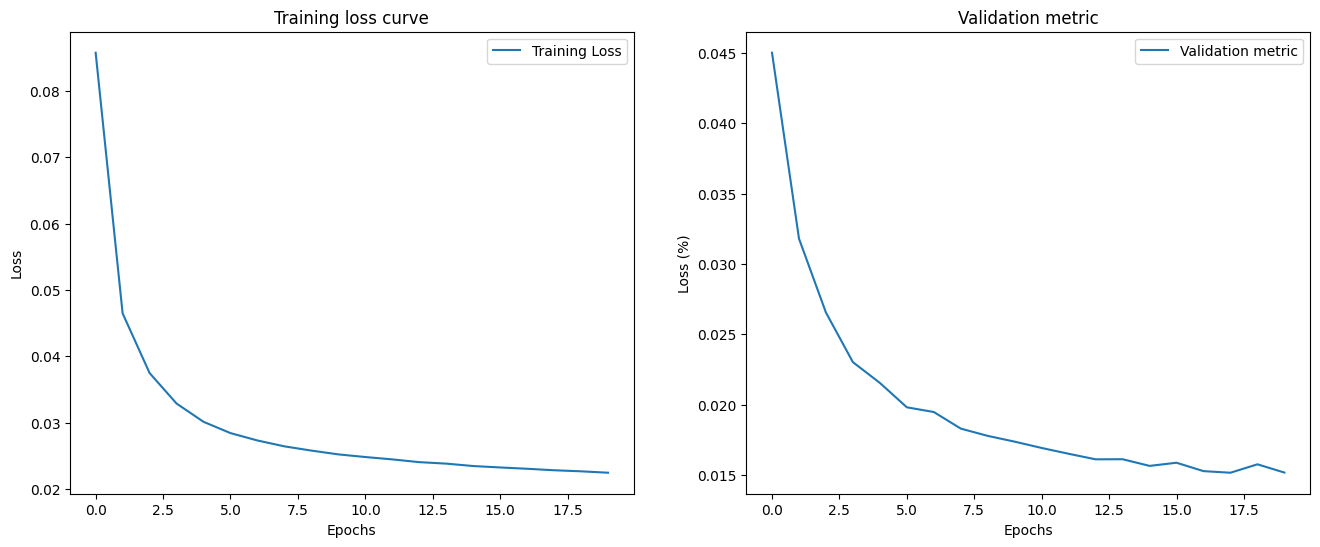

In [14]:
# Plot loss curves
plt.figure(figsize=(16, 6))

# Plotting global loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Training Loss')
plt.title('Training loss curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting validation metric
plt.subplot(1, 2, 2)
plt.plot(valid_metric_list, label='Validation metric')
plt.title('Validation metric')
plt.xlabel('Epochs')
plt.ylabel('Loss (%)')
plt.legend()

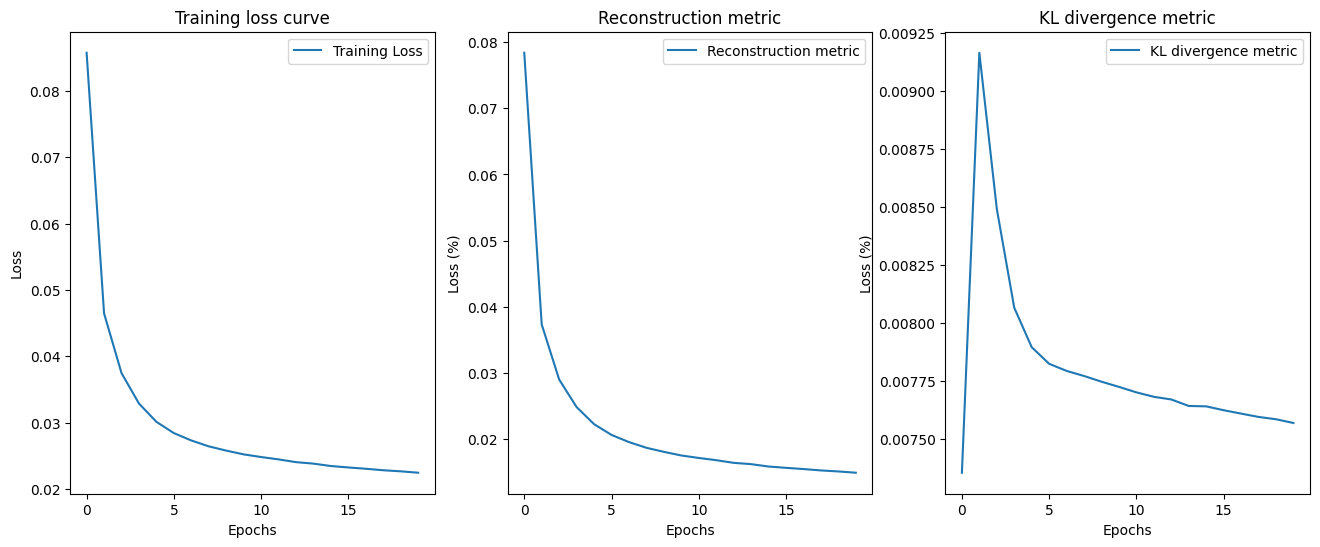

In [15]:
# Plot loss curves
plt.figure(figsize=(16, 6))

# Plotting global loss
plt.subplot(1, 3, 1)
plt.plot(train_loss_list, label='Training Loss')
plt.title('Training loss curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Reconstruction loss
plt.subplot(1, 3, 2)
plt.plot(recon_metric_list, label='Reconstruction metric')
plt.title('Reconstruction metric')
plt.xlabel('Epochs')
plt.ylabel('Loss (%)')
plt.legend()

# Plotting Qauntization loss
plt.subplot(1, 3, 3)
plt.plot(kld_metric_list, label='KL divergence metric')
plt.title('KL divergence metric')
plt.xlabel('Epochs')
plt.ylabel('Loss (%)')
plt.legend()

In [16]:
# initialize lists to monitor test loss and accuracy
test_metric = 0.0

model.eval() # prep model for *evaluation*

with torch.no_grad():  # Deactivate the gradient computations
    for batch_data in test_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        inputs = batch_data["image"].to(device)
        reconstruction, z_mu, z_sigma = model(inputs)
        # calculate the loss
        recon_val = reconstruction_loss(reconstruction.float(), inputs.float())
        test_metric += recon_val.item() * inputs.size(0)

# calculate and print avg test loss
test_metric = test_metric / len(test_loader.dataset)
print('Test reconstruction metric: {:.6f}\n'.format(test_metric))

# Prepare next cell
dataiter = iter(test_loader)

Test reconstruction metric: 0.015167



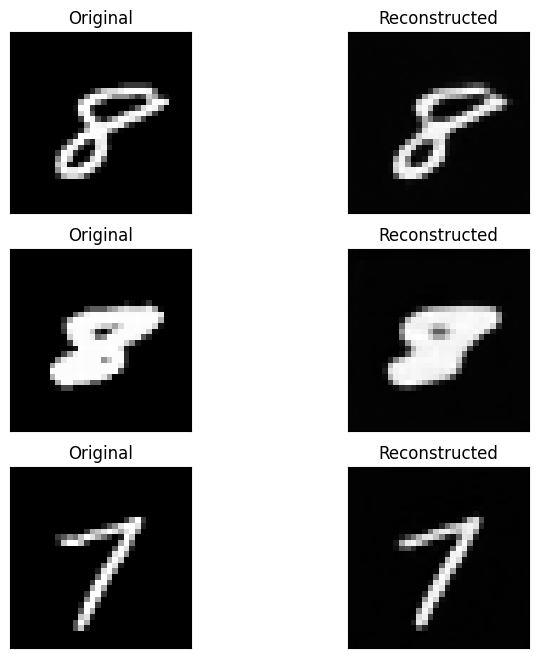

In [17]:
# obtain one batch of test images
batch_data = next(dataiter)

# get sample outputs
inputs = batch_data["image"].to(device)
labels = batch_data["label"]
recons, _, _ = model(inputs)
# reconstruction images for display
recons = recons.detach().cpu().numpy()
inputs = inputs.detach().cpu().numpy()

# Plot the image, label and prediction
fig = plt.figure(figsize=(8, 8))
for idx in range(3):
    ax = fig.add_subplot(3, 2, 2*idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(inputs[idx]), cmap='gray')
    ax.set_title('Original')
    ax = fig.add_subplot(3, 2, 2*idx+2, xticks=[], yticks=[])
    ax.imshow(np.squeeze(recons[idx]), cmap='gray')
    ax.set_title('Reconstructed')

In [18]:
downsampling_ratio = 5
counter = 0  # counter initialisation

model.eval() # prep model for *evaluation*
z_mu_accumulated = []
labels_accumulated = []

with torch.no_grad():  # Deactivate the gradient computations
    for batch_data in test_loader:
        counter += 1
        if counter % downsampling_ratio == 0:
            # forward pass: compute predicted outputs by passing inputs to the model
            inputs = batch_data["image"].to(device)
            labels = batch_data["label"].to(device)
            z_mu, _ = model.encode(inputs)
            z_mu_accumulated.append(z_mu.cpu().numpy())
            labels_accumulated.append(labels.cpu().numpy())

z_mu_accumulated = np.concatenate(z_mu_accumulated, axis=0)
labels_accumulated = np.concatenate(labels_accumulated, axis=0)

z_mu_flattened = z_mu_accumulated.reshape(z_mu_accumulated.shape[0], -1)
print(f"Size of the latent matrix passed to the t-SNE method (Nb Sample, vector dimensionality) = {z_mu_flattened.shape}")

# Apply t-SNE to reduce the dimensionality to 2 and allows a visualization of the latent space
tsne = TSNE(n_components=2, random_state=42)
z_mu_tsne = tsne.fit_transform(z_mu_flattened)


Size of the latent matrix passed to the t-SNE method (Nb Sample, vector dimensionality) = (2368, 256)


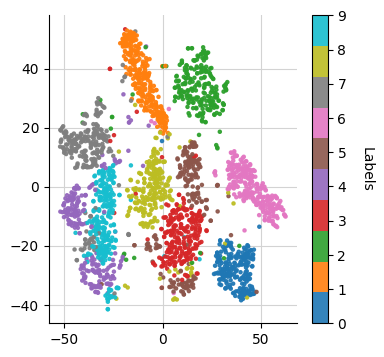

In [19]:
show_grid = True
fig, ax = plt.subplots(figsize=(8, 8) if not show_grid else (4, 4))

# create a scatter plot of the embeddings, colored by the labels
scatter = ax.scatter(
    x=z_mu_tsne[:, 0],
    y=z_mu_tsne[:, 1],
    c=labels_accumulated,
    cmap="tab10",
    s=5,
    alpha=0.9,
    zorder=2,
    )

# remove the top and right spines from the plot
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
# add a colorbar to the plot
cbar = plt.colorbar(scatter, ax=ax)
cbar.ax.set_ylabel("Labels", rotation=270, labelpad=20)
# if show is True, display the plot
if show_grid:
    # add a grid to the plot
    ax.grid(True, color="lightgray", alpha=1.0, zorder=0)
    # plt.show()
# otherwise, save the plot to a file and close the figure
else:
    plt.savefig("latent_space.png", bbox_inches="tight")
    plt.close()

torch.Size([32, 1, 32, 32])
The input image is of size torch.Size([1, 1, 32, 32])
The latent sample is of size torch.Size([1, 4, 8, 8])
The reconstrudted image is of size torch.Size([1, 1, 32, 32])


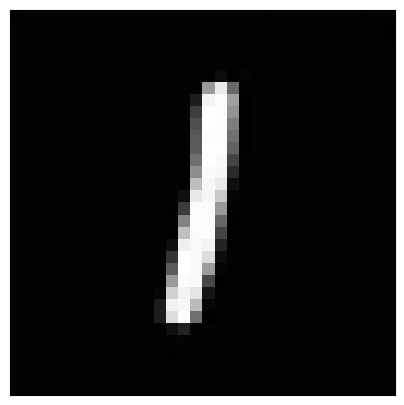

In [20]:
random_generation = False

if random_generation:
    z_mu = torch.randn(1, 4, 8, 8).to(device)
else:
    inputs = batch_data["image"].to(device)
    print(inputs.shape)
    input = inputs[31]
    input = input.unsqueeze(0)
    print(f"The input image is of size {input.shape}")
    z_mu, _ = model.encode(input)

print(f"The latent sample is of size {z_mu.shape}")

# Decode latent sample
reconstruction = model.decode(z_mu)
print(f"The reconstrudted image is of size {reconstruction.shape}")

img = reconstruction.squeeze().detach().cpu().numpy()
img = np.squeeze(img)

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111, xticks=[], yticks=[])
ax.imshow(img, cmap='gray')


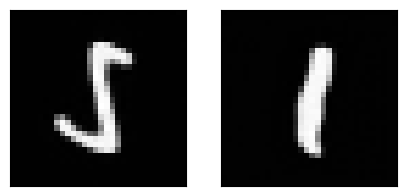

In [21]:
# Randomly select two points in the latent space
inputs = batch_data["image"].to(device)
input = inputs[0]
input = input.unsqueeze(0)
latent_1, _ = model.encode(input)
input = inputs[1]
input = input.unsqueeze(0)
latent_2, _ = model.encode(input)

synthetic_1 = model.decode(latent_1)
synthetic_2 = model.decode(latent_2)

img_1 = synthetic_1.squeeze().detach().cpu().numpy()
img_1 = np.squeeze(img_1)
img_2 = synthetic_2.squeeze().detach().cpu().numpy()
img_2 = np.squeeze(img_2)

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,2,1, xticks=[], yticks=[])
ax.imshow(img_1, cmap='gray')
ax = fig.add_subplot(1,2,2, xticks=[], yticks=[])
ax.imshow(img_2, cmap='gray')


In [22]:
def interpolate_images(model, latent_1, latent_2, steps=10):
    # Interpolate between point1 and point2 in the latent space

    latent_1.to(device)
    latent_2.to(device)
    t_values = torch.linspace(0, 1, steps).to(device)
    latent_tmp = [torch.lerp(latent_1, latent_2, t).to(device) for t in t_values]
    latent_interp = torch.stack([latent.squeeze(0) for latent in latent_tmp], dim=0)
    synthetic_interp = model.decode(latent_interp)

    # Return images as a list after detaching and converting to numpy
    return [img.squeeze().detach().cpu().numpy() for img in synthetic_interp]

def save_animation_as_gif(images, filename="animation.gif", interval=200):
    fig, ax = plt.subplots(figsize = (4,4))
    img_display = ax.imshow(images[0], cmap="gray", vmin=0, vmax=1)
    ax.axis("off")

    def update(frame):
        img_display.set_data(images[frame])
        return [img_display]

    ani = FuncAnimation(fig, update, frames=len(images), interval=interval, blit=True)
    ani.save(filename, writer="pillow", fps=1000//interval)
    plt.close(fig)


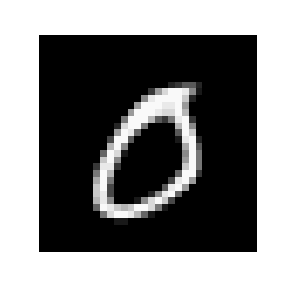

In [ ]:
# Interpolate between the two points and decode to generate images
images = interpolate_images(model, latent_1, latent_2, steps=64)

# Animate the interpolated images
filename = "mnist_interpolation.gif"
save_animation_as_gif(images, filename=filename, interval=100)

# Affiche le GIF dans Jupyter
display(Image(filename=filename))